## Libraries

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
tqdm.pandas()
import pickle
from collections import defaultdict
import statistics
import math
import numpy as np
import copy

C:\Users\Michelangelo\anaconda3\envs\EnvTensorflow\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## PageRank algorithm

In [229]:
# From https://en.wikipedia.org/wiki/PageRank
def pagerank(M, num_iterations: int = 100, d: float = 0.85):
    """PageRank: The trillion dollar algorithm.

    Parameters
    ----------
    M : numpy array
        adjacency matrix where M_i,j represents the link from 'j' to 'i', such that for all 'j'
        sum(i, M_i,j) = 1
    num_iterations : int, optional
        number of iterations, by default 100
    d : float, optional
        damping factor, by default 0.85

    Returns
    -------
    numpy array
        a vector of ranks such that v_i is the i-th rank from [0, 1],
        v sums to 1

    """
    N = M.shape[1]
    
    v = np.random.rand(1, N)
    # v = np.random.rand(N, 1)
    v = v / np.sum(v)
    M_hat = (d * M + (1 - d) / N)
    for i in range(num_iterations):
        v = v @ M_hat # M_hat @ v
        # v = M_hat @ v # M_hat @ v
    return v

# HWGraph class

In [248]:
class HWGraph:
    def __init__(self, edge_df, category_df=None, names_df=None):
        nodes = pd.concat([edge_df.Source, edge_df.Target]).unique()
        edges = dict()
        
        for node in nodes:
            edges[node] = []
        for s, t in edge_df.values:
            edges[s].append(t)
            
        self.edges = edge_df
        
        self.nodes = pd.DataFrame.from_dict(data={'Node': edges.keys(), 'Neighbour': edges.values()}).set_index('Node')
        self.nodes = self.nodes.join(self.in_degree(False, False)).join(self.out_degree(False, False), 
                                                                        lsuffix='In', rsuffix='Out').fillna(0)
        
        if category_df is not None:
            self.set_category(category_df)
            
        if names_df is not None:
            self.set_names(names_df)
        
        self.n_nodes = len(self.nodes)
        self.n_edges = len(self.edges)
        
    
    def set_category(self, category_df):
        self.nodes = self.nodes.join(category_df.Category)
    
    def set_names(self, names_df):
        self.nodes = self.nodes.join(names_df.Names)
    
    def is_directed(self):
        n_source, n_target = self.edges.nunique()
        if n_source != n_target:
            return True
        pass #...

    def out_degree(self, average_degree=True, centrality=True):
        if average_degree:
            return self.edges.groupby('Source').size().sum() / self.n_nodes
        else:
            out_degree = self.edges.groupby('Source').count().rename(columns={'Target': 'OutDegree'})
            out_degree.index.rename('Node', inplace=True)
            if centrality:
                return out_degree / (self.n_nodes-1)
            return out_degree.OutDegree
    
    def in_degree(self, average_degree=True, centrality=True):
        if average_degree:
            return self.edges.groupby('Target').size().sum() / self.n_nodes
        else:
            in_degree = self.edges.groupby('Target').count().rename(columns={'Source': 'InDegree'})
            in_degree.index.rename('Node', inplace=True)
            if centrality:
                return in_degree / (self.n_nodes-1)
            return in_degree.InDegree
    
    def density(self):
        return self.n_edges / (self.n_nodes * (self.n_nodes - 1))
    
    def plot_degree_distr(self, plot_in_degree=True, plot_out_degree=True, log=True):
        # Plot In Degree
        if plot_in_degree:
            degrees_in = self.in_degree(False, False).values
            plt.figure(figsize=(16,9))
            plt.title('In Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('In Degree', size=18)
            plt.hist(degrees_in, 100, log=log, density=True)
            plt.show()
        
        # Plot Out Degree
        if plot_out_degree:
            degrees_out = self.out_degree(False, False).values
            plt.figure(figsize=(16,9))
            plt.title('Out Degree Distribution', size=22)
            plt.ylabel('Prob.', size=18)
            plt.xlabel('Out Degree', size=18)
            plt.hist(degrees_out, 100, log=log, density=True)
            plt.show()
    
    def bfs(self, v, d, return_names=False, return_distances=False):
        actual_nodes = set(self.nodes.loc[v].Neighbour)
        next_nodes = set()
        visited = set([v])
        dist = {v : 0}
        i = 0
        while i < d:
            visited = visited.union(actual_nodes)
            
            while actual_nodes:
                n = actual_nodes.pop()
                if return_distances and n not in dist:
                    dist[n] = i + 1
                next_nodes = next_nodes.union(set(self.nodes.loc[n].Neighbour).difference(visited))
                    
            if not next_nodes:
                break
                
            actual_nodes = next_nodes
            next_nodes = set()
            i += 1
        if return_names:
            if return_distances:
                return self.nodes.loc[visited][['Names']].join(pd.Series(dist, 
                                                                         name='Distances')).sort_index()
            return self.nodes.loc[visited][['Names']]
        
        if return_distances:
            return visited, dist
        return visited
    
    def find_distance(self, source, targets, test_connectivity=False, inf_dist=True):
        max_distance = math.inf
        actual_nodes = set(self.nodes.loc[source].Neighbour)
        next_nodes = set()
        visited = set([source])
        dist = {source : 0}
        i = 0
        
        while i < max_distance and not targets.issubset(visited):
            print(f'Inizio i:{i} len actual_nodes: {len(actual_nodes)}')
            visited = visited.union(actual_nodes)
            
            while actual_nodes:
                n = actual_nodes.pop()
                if (n in targets) and (n not in dist):
                    dist[n] = i + 1
                next_nodes = next_nodes.union(set(self.nodes.loc[n].Neighbour).difference(visited))
                    
            if not next_nodes:
                break
                
            actual_nodes = next_nodes
            next_nodes = set()
            print(f'Fine i:{i}')
            i += 1
        
        if test_connectivity and not targets.issubset(visited):
            print("Not possible!")
            return
            
        dist_df = pd.DataFrame({'Nodes': dist.keys(), 'Distances': dist.values()})
        print('Fine creazione dist_df')
        
        if inf_dist:
            unreachable_targets = targets.difference(dist.keys())
            print('Inizio append nodi non raggiungibili')
            for node in unreachable_targets:
                dist_df.append({'Nodes': node, 'Distances': math.inf}, ignore_index=True)
            print('Fine append nodi non raggiungibili')
                  
        dist_df.set_index('Nodes', inplace=True)
                  
        return dist_df
    
#     def find_distance(self, source, targets, test_connectivity=False, inf_dist=True):
#         reacheable = self.bfs(source, math.inf, True, True).reset_index()[['Node', 'Distances']]
#         print('Trovati i raggiungibili')
#         
#         if test_connectivity and (not targets.issubset(reacheable.Node)):
#             print("Not possible!")
#             return
#         
#         if inf_dist:
#             reachable_targets = targets.intersection(reacheable.Node)
#         else:
#             reachable_targets = targets
#             
#         visited = reacheable.loc[reacheable.Node.isin(reachable_targets)]
#         print('Fine visited raggiungibili')
#         
#         if inf_dist:
#             unreachable_targets = targets.difference(reachable_targets)
#             for node in unreachable_targets:
#                 visited.append({'Node': node, 'Distances': math.inf}, ignore_index=True)
#             print('Fine visited non raggiungibili')
#         
#         visited = visited.loc[visited.Node.isin(targets)]
#         
#         visited.rename(columns={'Node': 'Nodes'}, inplace=True)
#         visited.set_index('Nodes', inplace=True)
#         print('fine find distances')
#         return visited.sort_index()
        
    def min_clicks(self, C, p):
        C_nodes = self.nodes[self.nodes.Category == C]
        v = C_nodes.InDegree.idxmax()
        
        visited = self.find_distance(v, p, True, inf_dist=False)
        
        if visited is not None:
            return visited.Distances.max()
    
    def contract(self):
        edges = self.edges.copy()
        
        if (edges.Source == edges.Target).any():
            edges = edges[~(edges.Source == edges.Target)]
            
        n_nodes = pd.concat([edges.Source, edges.Target]).nunique()
        
        while n_nodes > 2:
            s, t = edges.sample().values[0]
            
            # Removes the edges between s and t, in both directions
            edges = edges[~((edges.Source == s) & (edges.Target == t))]
            edges = edges[~((edges.Source == t) & (edges.Target == s))]
            
            # Remove node t, moving its edges to s
            edges.loc[edges.Source == t, 'Source'] = s
            edges.loc[edges.Target == t, 'Target'] = s
            
            # Updates n_nodes
            n_nodes = pd.concat([edges.Source, edges.Target]).nunique()
            
            # If the graph is not connected return 0
            if n_nodes > len(edges):
                return 0
            
        return len(edges)
        
    def min_link_to_disconnect(self, C1, C2):
        nodes = self.nodes[(self.nodes.Category == C1) | (self.nodes.Category == C2)].index
        edges = self.edges[self.edges.Source.isin(nodes) & self.edges.Target.isin(nodes)]
        # Creates the graph
        G = HWGraph(edges)
        
        if G.n_nodes == 0:
            return 0
        
        min_links = math.inf
        for i in range(int((G.n_nodes**2) * math.log(G.n_nodes))):
            res = G.contract()
            if res < min_links:
                min_links = res
                if min_links == 0:
                    return 0
                
        return min_links
    
    def shortest_path_category(self, C1, C2):
        # Nodes
        nodes1 = set(self.nodes[self.nodes.Category == C1].index.values)
        nodes2 = set(self.nodes[self.nodes.Category == C2].index.values)
        
        dist = []
        
        print(f'C1: {C1}, C2: {C2}')
        print(f'Nodes 1 len: {len(nodes1)}\n Nodes 2 len: {len(nodes2)}')
        for n in nodes1:
            distances = self.find_distance(n, nodes2)
            print(f'Fine da {n} a node2 [len = {len(nodes2)}]')
            dist.append(distances.Distances.values)
        dist = np.array(dist)
        
        return dist
                            
    def distance_from_category(self, C):
        distance = pd.DataFrame(columns=['C0', 'Ci', 'Dist'])
        categories = self.nodes.Category.unique()
        categories = categories[categories != C]
        
        for Ci in categories:
            distance.append((C, Ci, np.median(self.shortest_path_category(C, Ci))), 
                            ignore_index=True)
            print(distance.iloc[-1])
        
        return distance.sort_values('Dist', ascending=False)
    
    def category_rank(self):
        # Add the source and the target category
        edges = self.edges.join(self.nodes.Category, on='Source').join(self.nodes.Category, on='Target', lsuffix='Source', rsuffix='Target')
        categories_edges = edges.groupby(['CategorySource', 'CategoryTarget']).size()

        categories = pd.concat([edges.CategorySource, edges.CategoryTarget]).unique()
        n_categories = categories.size
        M = np.zeros((n_categories, n_categories))
        for i in range(n_categories):
            for j in range(n_categories):
                if (categories[i], categories[j]) in categories_edges.index:
                    M[i,j] = categories_edges.loc[categories[i], categories[j]]
        
        sums = M.sum(axis=1)
        if (sums == 0).any():
            M[sums == 0] += 1
        M /= sums.reshape(n_categories, 1)
        
        v = pagerank(M).flatten()
        return pd.DataFrame({'Category': categories, 'PageRank': v}).sort_values('PageRank', ascending=False)

# Load Datasets
## Read file with edges

In [4]:
df_edges = pd.read_csv('./data/wikigraph_reduced.csv',sep='\t',index_col=0,names=['Source','Target'],header=0)
df_edges.reset_index(drop=True,inplace=True)

## Read file with Categories

In [5]:
df_category = pd.read_csv("./data/wiki-topcats-categories.txt",sep=';',names=['Category','Articles'],header=0)
df_category['Category'] = df_category.Category.apply(lambda x: x.split(':')[1])
df_category['Articles'] = df_category.Articles.apply(lambda x : list(map(int,x.split())))
# Find the number of articles for each category
df_category['lens'] = [len(x) for x in df_category['Articles']]
# Removes the categories whose number of articles in less than 5000 and more than 30000.
df_category = df_category.loc[(df_category['lens']>5000) & (df_category['lens']<30000)]

In [6]:
df_category

,Category,Articles,lens
867,English_footballers,"[22860, 28411, 28961, 28979, 29264, 29573, 295...",9237
868,The_Football_League_players,"[14003, 23536, 27109, 27348, 27459, 27989, 280...",9467
875,Association_football_forwards,"[26876, 26877, 26879, 26887, 26892, 26904, 269...",6959
899,Association_football_midfielders,"[14003, 15291, 23536, 26880, 26882, 26885, 268...",8270
948,Association_football_defenders,"[15217, 22860, 26873, 26878, 26881, 26898, 269...",6668
2790,Harvard_University_alumni,"[77, 1013, 1271, 1663, 1779, 1843, 2212, 3193,...",6154
4159,Major_League_Baseball_pitchers,"[79, 24213, 33054, 37167, 53973, 63107, 69823,...",6580
5618,Members_of_the_United_Kingdom_Parliament_for_E...,"[29098, 29493, 29585, 30255, 30389, 30505, 306...",6546
6066,Indian_films,"[1308, 29286, 53565, 70274, 70275, 70797, 1233...",5913
6794,Year_of_death_missing,"[98, 126, 227, 1823, 2170, 2223, 13215, 14003,...",7851


### Now we verify that our articles belong to these filtered categories

In [8]:
categories_articles = set(df_category.Articles.sum())
our_articles = set(pd.concat([df_edges.Source, df_edges.Target]).unique())

In [11]:
if our_articles.issubset(categories_articles):
    print('Our articles belong to the filtered categories.')
else:
    print("Our articles don't belong to the filtered categories.")

Our articles belong to the filtered categories.


### Select a random category for each article

In [36]:
df_article = pd.concat([pd.DataFrame(data = {'Articles': df_category.loc[i].Articles, 
                                             'Category': df_category.loc[i].Category}) for i in df_category.index], 
                       ignore_index=True)
rand_article = df_article.groupby('Articles').sample()
df_article_category = pd.DataFrame(data={'Articles': rand_article.Articles, 'Category': rand_article.Category})
df_article_category.set_index('Articles', inplace=True)

In [8]:
df_article_category

,Category
Articles,
55,English-language_films
77,Harvard_University_alumni
79,Major_League_Baseball_pitchers
95,Debut_albums
98,Year_of_death_missing
...,...
1790843,Harvard_University_alumni
1791481,English-language_films
1791482,Association_football_midfielders


In [12]:
# with open("./data/article-category.csv", "w") as article_category_file:
#     article_category_file.write(df_article_category.reset_index().to_csv(index=False).replace('\r', ''))
df_article_category = pd.read_csv("./data/article-category.csv")
df_article_category.set_index('Articles', inplace=True)

## Read file with page names

In [13]:
df_names = pd.read_csv("./data/wiki-topcats-page-names.txt", header=None, names=['Names'])
df_names['Names'] = df_names.Names.apply(lambda x: x.split(' ', 1)[1])

In [14]:
df_names

,Names
0,Chiasmal syndrome
1,Kleroterion
2,Pinakion
3,LyndonHochschildSerre spectral sequence
4,Zariski's main theorem
...,...
1791484,Noadiah Russell (Yale founder)
1791485,Cornus officinalis
1791486,Peter Grummitt
1791487,Baron Estcourt


# Create the Graph

In [15]:
G = HWGraph(df_edges, category_df=df_article_category, names_df=df_names)

In [16]:
G.nodes

,Neighbour,InDegree,OutDegree,Category,Names
Node,,,,,
95,[1185516],0.0,1.0,Debut_albums,This Way (Hana Pestle album)
108,"[1059989, 1062426, 1161925]",0.0,3.0,Debut_albums,Born Innocent (Redd Kross album)
134,"[541222, 1061485, 1163610, 1163783]",5.0,4.0,English-language_films,San Quentin (1937 film)
153,"[744272, 1064807, 1065282, 1085943, 1125916, 1...",5.0,9.0,English-language_films,35 and Ticking
167,"[645690, 804311]",2.0,2.0,Place_of_birth_missing_(living_people),Donna Dubinsky
...,...,...,...,...,...
1789654,[],1.0,0.0,English-language_films,Allan Quatermain and the Temple of Skulls
1356290,[],1.0,0.0,English-language_films,The Cottage (film)
1053684,[],1.0,0.0,American_television_actors,Eric Lutes


# Answers

## Question 1

In [45]:
if G.is_directed():
    print('The graph is directed')
else:
    print('The graph is not directed')

The graph is directed


In [46]:
print(f'We are considering {G.n_nodes} articles.')

We are considering 98343 articles.


In [47]:
print(f'There are {G.n_edges} hyperlink between pages.')

There are 483094 hyperlink between pages.


In [48]:
print(f'The average number of links in an arbitrary page is {G.out_degree()}')
print(f'Graph density: {G.density()}')

The average number of links in an arbitrary page is 4.912337431235573
Graph density: 4.9951571365597335e-05


The graph is sparse

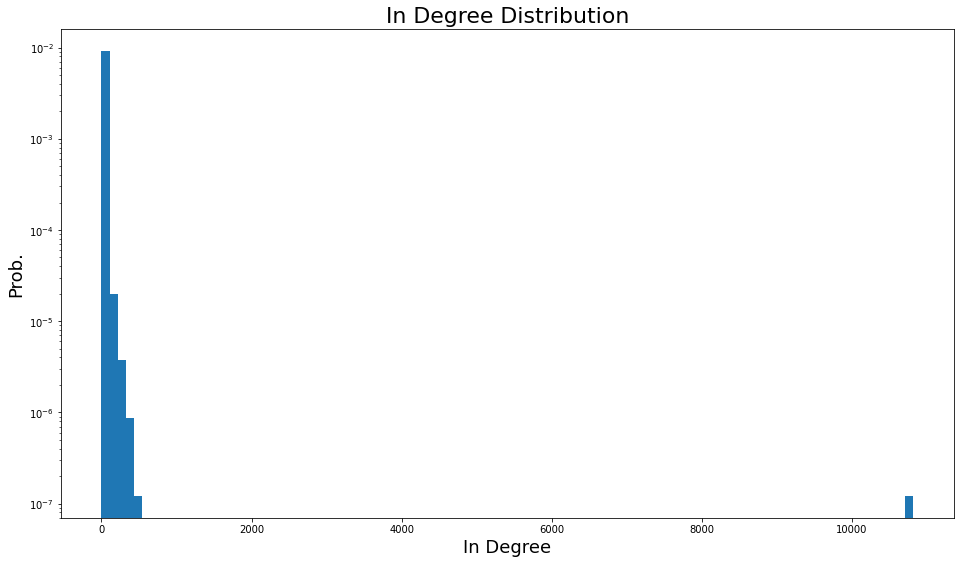

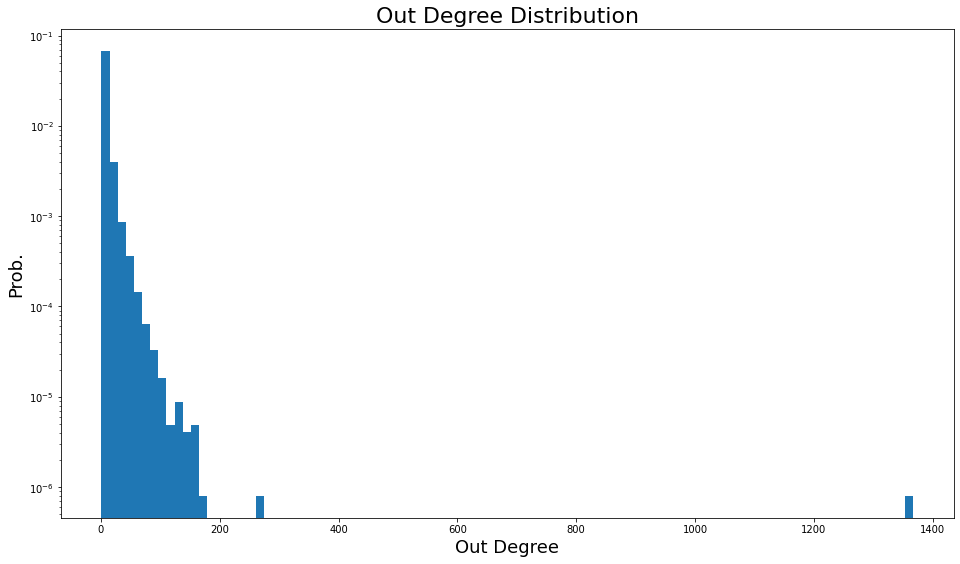

In [49]:
G.plot_degree_distr()

## Question 2

In [23]:
n, d = G.bfs(95, math.inf, return_names=True, return_distances=True) # spiegare meglio che succede

In [31]:
n.join(pd.Series(d, name='Distances')).sort_index()

,Names,Distances
Node,,
786432,Negoiu River (Cerna),10
786433,Sterminos River (Cerna),11
786434,Cioara River (Baldovin),10
786435,Baldovin River,9
786436,Vaa River,9
...,...,...
786421,Alun River,11
786428,Luncani River,10
573134,The Dutiful Dub,6


## Question 3

In [37]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 3
n_pages = np.random.randint(1, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f"To reach the pages {p}, belonging to the category {C}, starting from the category's most central article it requires at least {min_click} clicks.")
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}, starting from the category's most central article.")

Inizio i:0 len actual_nodes: 107
Fine i:0
Inizio i:1 len actual_nodes: 968
Fine i:1
Inizio i:2 len actual_nodes: 9953
Fine i:2
Fine creazione dist_df
To reach the pages {220222, 572807}, belonging to the category American_films, starting from the category's most central article it requires at least 3 clicks.


In [30]:
C = G.nodes.Category.sample().iloc[0]
max_pages = 20
n_pages = np.random.randint(5, max_pages)
p = set(G.nodes[G.nodes.Category == C].sample(n_pages, replace=True).index.tolist())
min_click = G.min_clicks(C, p)
if min_click is not None:
    print(f'To reach the pages {p}, belonging to the category {C}, it requires at least {min_click} clicks.')
else:
    print(f"It's not possible to reach all the pages {p}, belonging to the category {C}.")

Inizio i:0 len actual_nodes: 17
Fine i:0
Inizio i:1 len actual_nodes: 13
Fine i:1
Inizio i:2 len actual_nodes: 24
Fine i:2
Inizio i:3 len actual_nodes: 46
Fine i:3
Inizio i:4 len actual_nodes: 113
Fine i:4
Inizio i:5 len actual_nodes: 736
Fine i:5
Inizio i:6 len actual_nodes: 7894
Fine i:6
Inizio i:7 len actual_nodes: 20960
Fine i:7
Inizio i:8 len actual_nodes: 13143
Fine i:8
Inizio i:9 len actual_nodes: 6489
Fine i:9
Inizio i:10 len actual_nodes: 5633
Fine i:10
Inizio i:11 len actual_nodes: 4773
Fine i:11
Inizio i:12 len actual_nodes: 2467
Fine i:12
Inizio i:13 len actual_nodes: 985
Fine i:13
Inizio i:14 len actual_nodes: 409
Fine i:14
Inizio i:15 len actual_nodes: 160
Fine i:15
Inizio i:16 len actual_nodes: 85
Fine i:16
Inizio i:17 len actual_nodes: 34
Fine i:17
Inizio i:18 len actual_nodes: 13
Fine i:18
Inizio i:19 len actual_nodes: 5
Fine i:19
Inizio i:20 len actual_nodes: 3
Fine i:20
Inizio i:21 len actual_nodes: 2
Fine i:21
Inizio i:22 len actual_nodes: 2
Fine i:22
Inizio i:23 le

## Question 4

In [55]:
C1, C2 = np.random.choice(G.nodes.Category.unique(), 2)
print(f"The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories {C1} or {C2}, is {G.min_link_to_disconnect(C1, C2)}")

The minimum number of hyperlinks we have to remove in order to disconnect two random nodes, belonging to the categories American_television_actors or American_films, is 0


## Question 5

In [27]:
C = G.nodes.Category.sample().iloc[0]
C

'Harvard_University_alumni'

In [28]:
G.distance_from_category(C)

C1: Harvard_University_alumni, C2: Debut_albums
Nodes 1 len: 2964
 Nodes 2 len: 2553
Inizio i:0 len actual_nodes: 2
Fine i:0
Inizio i:1 len actual_nodes: 8
Fine i:1
Inizio i:2 len actual_nodes: 65
Fine i:2
Inizio i:3 len actual_nodes: 815
Fine i:3
Inizio i:4 len actual_nodes: 9450
Fine i:4
Inizio i:5 len actual_nodes: 21041
Fine i:5
Inizio i:6 len actual_nodes: 12202
Fine i:6
Inizio i:7 len actual_nodes: 6957
Fine i:7
Inizio i:8 len actual_nodes: 5638
Fine i:8
Inizio i:9 len actual_nodes: 4258
Fine i:9
Inizio i:10 len actual_nodes: 2177
Fine i:10
Inizio i:11 len actual_nodes: 839
Fine i:11
Inizio i:12 len actual_nodes: 331
Fine i:12
Inizio i:13 len actual_nodes: 127
Fine i:13
Inizio i:14 len actual_nodes: 56
Fine i:14
Inizio i:15 len actual_nodes: 31
Fine i:15
Inizio i:16 len actual_nodes: 7
Fine i:16
Inizio i:17 len actual_nodes: 3
Fine i:17
Inizio i:18 len actual_nodes: 2
Fine i:18
Inizio i:19 len actual_nodes: 2
Fine i:19
Inizio i:20 len actual_nodes: 1
Fine i:20
Inizio i:21 len act

Fine append nodi non raggiungibili
Fine da 311352 a node2 [len = 2553]
Inizio i:0 len actual_nodes: 8
Fine i:0
Inizio i:1 len actual_nodes: 51
Fine i:1
Inizio i:2 len actual_nodes: 685
Fine i:2
Inizio i:3 len actual_nodes: 8723
Fine i:3
Inizio i:4 len actual_nodes: 21476
Fine i:4
Inizio i:5 len actual_nodes: 13008
Fine i:5
Inizio i:6 len actual_nodes: 6274
Fine i:6
Inizio i:7 len actual_nodes: 5339
Fine i:7
Inizio i:8 len actual_nodes: 4523


KeyboardInterrupt: 

## Question 6

In [249]:
G = HWGraph(df_edges, category_df=df_article_category, names_df=df_names) #TEMP

In [250]:
G.category_rank()

,Category,PageRank
5,American_film_actors,0.146215
1,English-language_films,0.097378
8,Main_Belt_asteroids,0.083784
4,American_television_actors,0.072805
15,The_Football_League_players,0.066614
16,English_footballers,0.064383
17,Members_of_the_United_Kingdom_Parliament_for_E...,0.061219
3,American_films,0.055908
19,Rivers_of_Romania,0.048081
20,Major_League_Baseball_pitchers,0.046046
